# Array-assisted Phase Picker (APP) Tutorial 

### (Jiang Y R, Ning J Y, 2019)

### Tutorial Script created by Jeremy Wong @2020.05.27

Source Code and tutorial is written based on : https://github.com/baogegeJiang/Array-assisted-Phase-Picker

Array-assisted Phase Picker is a modified version of PhaseNet, an trained deeplearning model conducts seismic arrival-time picking. The modified Array-assisted phase picker introduce futher packages ultilizing the output of the AI to conduct futher analysis. The trained model detect and locate the arrival of the P-arrival and S-arrival of the input seimsic traces.



## Section 1 - Demonstrate the Pre-trained Model
### 1.1 Import Pre-trained Model from genMV3.py

In the folllowing, the model is imported via the script genMV3.py and updated with the weights pretrained with noise and without noise as selected. 

   - 'modelP_320000_0-2-15-with', 'modelS_320000_0-2-15-with': 
         models trained with typical noise
   - 'modelP_320000_100-2-15', 'modelS_320000_100-2-15':  
         models trained without typical noise
<figure>
<img src="img/Model_U_structure.png" height=70 />
<figcaption> Figure 1. Model Architecture of PhaseNet [Figure 5, Zhu W. & Beroza G. C.]
</figcaption>
</figure>

The structure of the model is a U-shape deep-neural network. Each 'layer' of the U shape consists of a 2D Convolutional layer (Conv2D) and a maxpooling layer (Maxpool). The combination of the Conv2D and Maxpool layers allows the model to recogize different patterns in the time series and concancates 




From the 


In [1]:
#### Import Relevant Packages
from keras.utils import plot_model


### Import model from genMV3.py
from genMV3 import genModel

modelP = genModel()
modelP.load_weights('modelP_320000_0-2-15-with')
modelS = genModel()
modelS.load_weights('modelS_320000_0-2-15-with')

# show input shape of the model
print("Input shape of the model :" + str(modelP.input_shape))

# Plot the structure of the model (output: img/modelP.png)
if True:               # Select True to plot the structure of the model
    plot_model(modelP, 
               to_file="img/modelP.png",
               show_shapes=True,
               show_layer_names=True,
               rankdir="TB", # TB - vertical plot; LR - horizontal plot
               expand_nested=True, # whether to expand nested models into clusters
               dpi=96)


Using TensorFlow backend.
/Users/jeremy/opt/anaconda3/envs/seismo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jeremy/opt/anaconda3/envs/seismo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jeremy/opt/anaconda3/envs/seismo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/User

Instructions for updating:
Colocations handled automatically by placer.
Input shape of the model :(None, 2000, 1, 3)


TypeError: plot_model() got an unexpected keyword argument 'expand_nested'

### 1.2 Import and organize data to feed the model

1) The seismic data shall be organized in the following format to feed to the model:
<center> <code> (n, 2000, 1, 3) </code> </center>

   - n: data slices count
   - 2000: sampling points in the time domain 40s, 50hz
   - 3: components [E, N, Z]

2) Preprocessing the data
   - Filter the data with bandpass of [2 Hz - 15 Hz] 

   <code> st.filter("bandpass", freqmin=2, freqmax=15) </code>

   - Normalize the waveform using the following

   `inputData /= inputData.std(axis=(1,2,3), keepdims=True)` 

3) Feed the model with the data

   <code> probP = modelP.predict(inputData) </code>

   <code> probS = modelS.predict(inputData) </code>

Returns: Probabilities of P and S arrivals

#### Import sample data from HKPS
In the following, we will detect and locate the P and S arrival time of the recent local earthquakes in HK of the seismic data recorded by Po Shan Station. The data can be fetched using `obspy.clients.fdsn.Client`.

Since the sampling of the seismic trace maybe different from 50 hz, we have to resample the trace into 50hz with lenght of 40 seconds.

In [2]:
import numpy as np
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

verbose = True
# Obtain data from HKPS station
client = Client('IRIS')
t1 = UTCDateTime("2020-01-04T22:55:30")
st = client.get_waveforms("HK","HKPS","","BH*", t1, t1 + 40)
if verbose:
    print(st)

# resample, filter and normalize
st.resample(50.0)
st.filter('bandpass',freqmin=2,freqmax=15)
st.normalize()



# Extract data from obspy.trace
data = np.zeros((1,2000,1,3))
for i in range(3):
    data[0,:,0,i] = st[i].data



### Feed to the model
probP = modelP.predict(data)
probS = modelS.predict(data) 

print(probP.shape)

3 Trace(s) in Stream:
HK.HKPS..BHE | 2020-01-04T22:55:30.019500Z - 2020-01-04T22:56:09.994500Z | 40.0 Hz, 1600 samples
HK.HKPS..BHN | 2020-01-04T22:55:30.019500Z - 2020-01-04T22:56:09.994500Z | 40.0 Hz, 1600 samples
HK.HKPS..BHZ | 2020-01-04T22:55:30.019500Z - 2020-01-04T22:56:09.994500Z | 40.0 Hz, 1600 samples
(1, 2000, 1, 1)


### 1.3 Plot and analysis the result

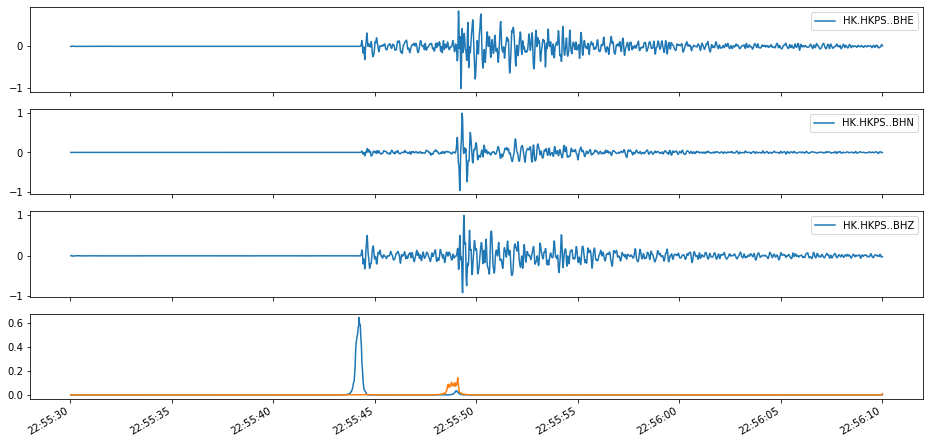

In [3]:
import matplotlib.pyplot as plt

def plot_results(st,probP,probS):
    # Plot stream with the probabilty of P ans S arrival predicted from the model
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(411)
    ax.plot(st[0].times("matplotlib"), st[0].data, label=st[0].id)
    ax.legend()
    ax.xaxis_date()
    ax = fig.add_subplot(412)
    ax.plot(st[0].times("matplotlib"), st[1].data, label=st[1].id)
    ax.legend()
    ax.xaxis_date()
    ax = fig.add_subplot(413)
    ax.plot(st[0].times("matplotlib"), st[2].data, label=st[2].id)
    ax.legend()
    ax.xaxis_date()
    ax = fig.add_subplot(414)
    ax.plot(st[0].times("matplotlib"),probP[0,:,0,0])
    ax.plot(st[0].times("matplotlib"),probS[0,:,0,0])
    ax.xaxis_date()
    fig.autofmt_xdate()
    plt.show()

plot_results(st, probP, probS)




## 2 - Advance usage of Array-assisted Phase-net

The developed version of he Phase Picker requires the following items to run the programme

### 2.1 Prerequsite for the APP programme 

#### 2.1.1 Station Information list file
net  sta  component  long/º  lat/º  elevation/m  rms_of_lon  rms_of_lat

`HK HKPS BH 104.55 31.00 0.0000 0.0000 0.0000`

    ```
    def generate_stationlist(st, stlst_file):
    """ Generate station list from obspy.stream
    """
        stlst = []
        for tr in st:
            stlst.append([tr.stats.network, tr.stats.station, tr.stats.channel,
                          tr.stats.longtitude, tr.stats.latitude, tr.stats.elevation,
                          0.0,0.0])
        with open(stlst_file, "w+") as file:
            for ls in stlst:
                file.write(" ".join(ls) + "\n")
    ```
Generate station infomration list

In [4]:
from obspy import read, Stream

##### Station list generator
def generate_stationlist(st, stlst_file):
    """ Generate station list from obspy.stream
    """
    stlst = []
    for tr in st:
        stlst.append([tr.stats.network, tr.stats.station, tr.stats.channel,
                      str(tr.stats.sac.stlo), str(tr.stats.sac.stla), str(tr.stats.sac.stel),
                      "0.0","0.0"])
    with open(stlst_file, "w+") as file:
        for ls in stlst:
            file.write(" ".join(ls) + "\n")
    print("Generated %s " % stlst_file)


# Read sac in a day to generate station list
st_loc = "/Users/jeremy/OneDrive - The Chinese University of Hong Kong/cu/academic/sources/program/seismology/tmp/2020/005"
stlist_file = "station_list"
_st = read(st_loc + '/*')
st = Stream()

# Select list of channel only (exclude V.., L..)
for chan in "BH*", "HH*","EH*":
    st += _st.select(channel=chan)

# Gen station list
generate_stationlist(st, stlist_file)

Generated station_list 


#### 2.1.2 File path function
A funtion that return the sacfile name list according to the input (net, station, component, date).

    ```
    def FileName(net, station, comp, YmdHMSJ):
        sacFileNames = list()
        c=comp[-1]
        if c=='Z':
            c='U'
        sacFileNames.append('data/'+net+'/'+station+'/'+net+'.'+YmdHMSJ['Y']+\
            YmdHMSJ['m']+YmdHMSJ['d']+'.'+station+'.'+c+'.SAC')
        return sacFileNames 

### 2.2 Run APP

In [5]:
# import relavant package
import os
import detecQuake
import trainPSV2 as trainPS
import sacTool
from obspy import UTCDateTime, read
import tool
from locate import locator

##### sac file function
def FileName(net, station, comp, YmdHMSJ):
    sac_dir = '/Users/jeremy/OneDrive - The Chinese University of Hong Kong/cu/academic/sources/program/seismology/tmp'
    sacFileNames = list()
    c=comp[-1]
    if c=='Z':
        c='U'
    #sacFileNames.append(sac_dir+net+'/'+station+'/'+net+'.'+YmdHMSJ['Y']+\
    #    YmdHMSJ['m']+YmdHMSJ['d']+'.'+station+'.'+c+'.SAC')
    sacFileNames.append(sac_dir+'/'+YmdHMSJ['Y']+'/'+YmdHMSJ['J']+'/'\
                        +YmdHMSJ['Y']+YmdHMSJ['J']+"000000.00"+station+'.'+comp)
    return sacFileNames


            
# Generate station list from sacfiles
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
workDir='/Users/jeremy/OneDrive - The Chinese University of Hong Kong/cu/academic/Final Year Project/ML/work/'# workDir: the dir to save the results
staLstFile='station_list'#station list file
bSec=UTCDateTime(2020,1,1).timestamp#begain date
eSec=UTCDateTime(2020,1,6).timestamp#end date
laL=[21, 24]#area: [min_latitude, max_latitude]
loL=[110, 120]#area: [min_longitude, max_longitude]
laN=35#subareas in latitude/the default is enough
loN=35#subareas in longitude
nameFunction=FileName# set to your own file path function

#####no need to change ##########
taupM=tool.quickTaupModel(modelFile='iaspTaupMat')# load pre-calculated travel time result to accelerate the computation speed of travel time 
modelL = [trainPS.loadModel('modelP_320000_100-2-15'),\
trainPS.loadModel('modelS_320000_100-2-15')]#load pre-trained model of P/S
staInfos=sacTool.readStaInfos(staLstFile) #load station information stored in staLstFile
aMat=sacTool.areaMat(laL,loL,laN,loN)#generate subareas according to laL,loL,laN,loN
staTimeML= detecQuake.getStaTimeL(staInfos, aMat, taupM=taupM)#calculate the travel time  range between each station and each subarea
quakeLs=list()# init the quakeLs to store results in memory

for date in range(int(bSec),int(eSec),86400):
    
    date=UTCDateTime(float(date))
    print('pick on ',date)
    staL = detecQuake.getStaL(staInfos, aMat, staTimeML,\
        modelL, date, getFileName=nameFunction,\
        mode='norm',f=[2,15])
    quakeLs.append(detecQuake.associateSta(staL, aMat, \
        staTimeML, timeR=10, maxDTime=3, N=1,locator=\
        locator(staInfos)))
    '''
    save:
    result's in  workDir+'phaseLst'
    result's waveform in  workDir+'output/'
    result's plot picture in  workDir+'output/'
    '''
    tool.saveQuakeLs(quakeLs, workDir+'phaseLst')
    tool.saveQuakeLWaveform(staL, quakeLs[-1], \
        matDir=workDir+'output/',\
            index0=-1500,index1=1500)
    detecQuake.plotResS(staL,quakeLs[-1],outDir=workDir+'output/')
    staL=[]# clear data  to save memory


/Users/jeremy/OneDrive - The Chinese University of Hong Kong/cu/academic/Final Year Project/ML/Array-assisted-Phase-Picker/mathFunc.py:86: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cmax" failed type inference due to: No conversion from none to int64 for '$200return_value.1', defined at None

File "mathFunc.py", line 101:
def cmax(a,tmin,winL,laout,aM):
    <source elided>
        aM[i-winL]+=a[i-winL]
        i+=1
        ^

[1] During: typing of assignment at /Users/jeremy/OneDrive - The Chinese University of Hong Kong/cu/academic/Final Year Project/ML/Array-assisted-Phase-Picker/mathFunc.py (101)

File "mathFunc.py", line 101:
def cmax(a,tmin,winL,laout,aM):
    <source elided>
        aM[i-winL]+=a[i-winL]
        i+=1
        ^

  @jit(int64(float32[:],float32,int64,int64,float32[:]))
/Users/jeremy/OneDrive - The Chinese University of Hong Kong/cu/academic/Final Year Project/ML/Array-assisted-Phase-Picker/mathFunc.py:86: Nu

warning cannot load mapTool
pick on  2020-01-01T00:00:00.000000Z
process on sta:  0
process on sta:  1
process on sta:  2
process on sta:  3
process on sta:  4
process on sta:  5
process on sta:  6
process on sta:  7
process on sta:  8
process on sta:  9
process on sta:  10
process on sta:  11
process on sta:  12
process on sta:  13
process on sta:  14
process on sta:  15
process on sta:  16
process on sta:  17
process on sta:  18
process on sta:  19
process on sta:  20
process on sta:  21
process on sta:  22
process on sta:  23
process on sta:  24
process on sta:  25
process on sta:  26
process on sta:  27
process on sta:  28
process on sta:  29
process on sta:  30
process on sta:  31
process on sta:  32
process on sta:  33
process on sta:  34
process on sta:  35
process on sta:  36
process on sta:  37
process on sta:  38
process on sta:  39
process on sta:  40
process on sta:  41
start 4102444710 30
pick on  2020-01-02T00:00:00.000000Z
process on sta:  0
process on sta:  1
process on